In [ ]:
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
!pip install open3d 
import open3d as o3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 422.5 MB 34 kB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 9.9 MB 33.8 MB/s 
     |████████████████████████████████| 3.2 MB 42.2 MB/s 
     |████████████████████████████████| 1.6 MB 53.1 MB/s 
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.0
    Uninstalling nbformat-5.7.0:
      Successfully uninstalled nbformat-5.7.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


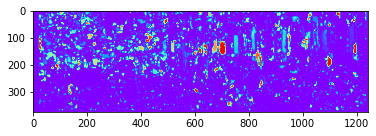

In [ ]:
import numpy as np
!pip install opencv-python
#import cv2 from matplotlib
import cv2
import matplotlib.pyplot as plt

imgL = cv2.imread('/content/drive/MyDrive/minor_project/2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_03/data/0000000014.png',cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('/content/drive/MyDrive/minor_project/2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_03/data/0000000021.png',cv2.IMREAD_GRAYSCALE)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'rainbow')
plt.show()


In [ ]:
print(f"Image resolution: {disparity.shape}")
print(f"Data type: {disparity.dtype}")
print(f"Min value: {np.min(disparity)}")
print(f"Max value: {np.max(disparity)}")

Image resolution: (375, 1242)
Data type: int16
Min value: -16
Max value: 240


In [ ]:
FX_DEPTH = 7.215377e+02
FY_DEPTH = 7.215377e+02
CX_DEPTH = 6.095593e+02
CY_DEPTH = 1.728540e+02

In [ ]:
# compute point cloud:
pcd = []
height, width = disparity.shape
for i in range(height):
   for j in range(width):
       z = disparity[i][j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       pcd.append([x, y, z])

In [ ]:
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

#pcd  = o3d.io.read_point_cloud(pcd_o3d)

#print(np.asarray(pcd.points).shape)
#print(np.asarray(pcd.colors).shape)

#o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
import numpy as np
import open3d as o3d
from functools import partial

class PointCloudVisualizer():
    def __init__(self):
        self.pcl = None
        # transform from camera to world orientation (Note the absolute position won't be correct)
        self.R_camera_to_world = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]]).astype(np.float64)
        self.vis = o3d.visualization.Visualizer()
        self.vis.create_window("[DepthAI] Open3D integration demo", 960, 540)
        self.isstarted = False

    def visualize_pcl(self, pcl_data, downsample=False):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pcl_data)
        pcd.remove_non_finite_points()
        if downsample:
            pcd = pcd.voxel_down_sample(voxel_size=0.03)
        # Remove noise
        # pcd = pcd.remove_statistical_outlier(30, 0.1)[0]
        if self.pcl is None:
            self.pcl = pcd
        else:
            self.pcl.points = pcd.points
        # Rotate the pointcloud such that it is in the world coordinate frame (easier to visualize)
        self.pcl.rotate(self.R_camera_to_world, center=np.array([0,0,0],dtype=np.float64))

        if not self.isstarted:
            self.vis.add_geometry(self.pcl)
            origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
            self.vis.add_geometry(origin)
            ctr = self.vis.get_view_control()
            ctr.set_zoom(0.3)
            # ctr.camera_local_rotate()
            # ctr.camera_local_translate()
            self.isstarted = True
        else:
            self.vis.update_geometry(self.pcl)
            self.vis.poll_events()
            self.vis.update_renderer()

    def close_window(self):
        self.vis.destroy_window()

In [ ]:
from __future__ import print_function

import os
import sys
import numpy as np
import cv2

BASE_DIR = os.path.dirname(os.path.abspath(__file__))
ROOT_DIR = os.path.dirname(BASE_DIR)
sys.path.append(os.path.join(ROOT_DIR, "mayavi"))
import kitti_util as utils
import argparse

try:
    raw_input  # Python 2
except NameError:
    raw_input = input  # Python 3

cbox = np.array([[0, 70.4], [-40, 40], [-3, 1]])


class kitti_object(object):
    """Load and parse object data into a usable format."""

    def __init__(self, root_dir, split="training", args=None):
        """root_dir contains training and testing folders"""
        self.root_dir = root_dir
        self.split = split
        print(root_dir, split)
        self.split_dir = os.path.join(root_dir, split)

        if split == "training":
            self.num_samples = 7481
        elif split == "testing":
            self.num_samples = 7518
        else:
            print("Unknown split: %s" % (split))
            exit(-1)

        lidar_dir = "velodyne"
        depth_dir = "depth"
        pred_dir = "pred"
        if args is not None:
            lidar_dir = args.lidar
            depth_dir = args.depthdir
            pred_dir = args.preddir

        self.image_dir = os.path.join(self.split_dir, "image_2")
        self.label_dir = os.path.join(self.split_dir, "label_2")
        self.calib_dir = os.path.join(self.split_dir, "calib")

        self.depthpc_dir = os.path.join(self.split_dir, "depth_pc")
        self.lidar_dir = os.path.join(self.split_dir, lidar_dir)
        self.depth_dir = os.path.join(self.split_dir, depth_dir)
        self.pred_dir = os.path.join(self.split_dir, pred_dir)

    def __len__(self):
        return self.num_samples

    def get_image(self, idx):
        assert idx < self.num_samples
        img_filename = os.path.join(self.image_dir, "%06d.png" % (idx))
        return utils.load_image(img_filename)

    def get_lidar(self, idx, dtype=np.float32, n_vec=4):
        assert idx < self.num_samples
        lidar_filename = os.path.join(self.lidar_dir, "%06d.bin" % (idx))
        print(lidar_filename)
        return utils.load_velo_scan(lidar_filename, dtype, n_vec)

    def get_calibration(self, idx):
        assert idx < self.num_samples
        calib_filename = os.path.join(self.calib_dir, "%06d.txt" % (idx))
        return utils.Calibration(calib_filename)

    def get_label_objects(self, idx):
        assert idx < self.num_samples and self.split == "training"
        label_filename = os.path.join(self.label_dir, "%06d.txt" % (idx))
        return utils.read_label(label_filename)

    def get_pred_objects(self, idx):
        assert idx < self.num_samples
        pred_filename = os.path.join(self.pred_dir, "%06d.txt" % (idx))
        is_exist = os.path.exists(pred_filename)
        if is_exist:
            return utils.read_label(pred_filename)
        else:
            return None

    def get_depth(self, idx):
        assert idx < self.num_samples
        img_filename = os.path.join(self.depth_dir, "%06d.png" % (idx))
        return utils.load_depth(img_filename)

    def get_depth_image(self, idx):
        assert idx < self.num_samples
        img_filename = os.path.join(self.depth_dir, "%06d.png" % (idx))
        return utils.load_depth(img_filename)

    def get_depth_pc(self, idx):
        assert idx < self.num_samples
        lidar_filename = os.path.join(self.depthpc_dir, "%06d.bin" % (idx))
        is_exist = os.path.exists(lidar_filename)
        if is_exist:
            return utils.load_velo_scan(lidar_filename), is_exist
        else:
            return None, is_exist
        # print(lidar_filename, is_exist)
        # return utils.load_velo_scan(lidar_filename), is_exist

    def get_top_down(self, idx):
        pass

    def isexist_pred_objects(self, idx):
        assert idx < self.num_samples and self.split == "training"
        pred_filename = os.path.join(self.pred_dir, "%06d.txt" % (idx))
        return os.path.exists(pred_filename)

    def isexist_depth(self, idx):
        assert idx < self.num_samples and self.split == "training"
        depth_filename = os.path.join(self.depth_dir, "%06d.txt" % (idx))
        return os.path.exists(depth_filename)


class kitti_object_video(object):
    """ Load data for KITTI videos """

    def __init__(self, img_dir, lidar_dir, calib_dir):
        self.calib = utils.Calibration(calib_dir, from_video=True)
        self.img_dir = img_dir
        self.lidar_dir = lidar_dir
        self.img_filenames = sorted(
            [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
        )
        self.lidar_filenames = sorted(
            [os.path.join(lidar_dir, filename) for filename in os.listdir(lidar_dir)]
        )
        print(len(self.img_filenames))
        print(len(self.lidar_filenames))
        # assert(len(self.img_filenames) == len(self.lidar_filenames))
        self.num_samples = len(self.img_filenames)

    def __len__(self):
        return self.num_samples

    def get_image(self, idx):
        assert idx < self.num_samples
        img_filename = self.img_filenames[idx]
        return utils.load_image(img_filename)

    def get_lidar(self, idx):
        assert idx < self.num_samples
        lidar_filename = self.lidar_filenames[idx]
        return utils.load_velo_scan(lidar_filename)

    def get_calibration(self, unused):
        return self.calib


def viz_kitti_video():
    video_path = os.path.join(ROOT_DIR, "dataset/2011_09_26/")
    dataset = kitti_object_video(
        os.path.join(video_path, "2011_09_26_drive_0023_sync/image_02/data"),
        os.path.join(video_path, "2011_09_26_drive_0023_sync/velodyne_points/data"),
        video_path,
    )
    print(len(dataset))
    for _ in range(len(dataset)):
        img = dataset.get_image(0)
        pc = dataset.get_lidar(0)
        cv2.imshow("video", img)
        draw_lidar(pc)
        raw_input()
        pc[:, 0:3] = dataset.get_calibration().project_velo_to_rect(pc[:, 0:3])
        draw_lidar(pc)
        raw_input()
    return


def show_image_with_boxes(img, objects, calib, show3d=True, depth=None):
    """ Show image with 2D bounding boxes """
    img1 = np.copy(img)  # for 2d bbox
    img2 = np.copy(img)  # for 3d bbox
    #img3 = np.copy(img)  # for 3d bbox
    #TODO: change the color of boxes
    for obj in objects:
        if obj.type == "DontCare":
            continue
        if obj.type == "Car":
            cv2.rectangle(
            img1,
            (int(obj.xmin), int(obj.ymin)),
            (int(obj.xmax), int(obj.ymax)),
            (0, 255, 0),
            2,
        )
        if obj.type == "Pedestrian":
            cv2.rectangle(
            img1,
            (int(obj.xmin), int(obj.ymin)),
            (int(obj.xmax), int(obj.ymax)),
            (255, 255, 0),
            2,
        )
        if obj.type == "Cyclist":
            cv2.rectangle(
            img1,
            (int(obj.xmin), int(obj.ymin)),
            (int(obj.xmax), int(obj.ymax)),
            (0, 255, 255),
            2,
        )
        box3d_pts_2d, _ = utils.compute_box_3d(obj, calib.P)
        if box3d_pts_2d is None:
            print("something wrong in the 3D box.")
            continue
        if obj.type == "Car":
            img2 = utils.draw_projected_box3d(img2, box3d_pts_2d, color=(0, 255, 0))
        elif obj.type == "Pedestrian":
            img2 = utils.draw_projected_box3d(img2, box3d_pts_2d, color=(255, 255, 0))
        elif obj.type == "Cyclist":
            img2 = utils.draw_projected_box3d(img2, box3d_pts_2d, color=(0, 255, 255))


        # project
        # box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
        # box3d_pts_32d = utils.box3d_to_rgb_box00(box3d_pts_3d_velo)
        # box3d_pts_32d = calib.project_velo_to_image(box3d_pts_3d_velo)
        # img3 = utils.draw_projected_box3d(img3, box3d_pts_32d)
    # print("img1:", img1.shape)
    cv2.imshow("2dbox", img1)
    # print("img3:",img3.shape)
    # Image.fromarray(img3).show()
    show3d = True
    if show3d:
        # print("img2:",img2.shape)
        cv2.imshow("3dbox", img2)
    if depth is not None:
        cv2.imshow("depth", depth)
    
    return img1, img2


def show_image_with_boxes_3type(img, objects, calib, objects2d, name, objects_pred):
    """ Show image with 2D bounding boxes """
    img1 = np.copy(img)  # for 2d bbox
    type_list = ["Pedestrian", "Car", "Cyclist"]
    # draw Label
    color = (0, 255, 0)
    for obj in objects:
        if obj.type not in type_list:
            continue
        cv2.rectangle(
            img1,
            (int(obj.xmin), int(obj.ymin)),
            (int(obj.xmax), int(obj.ymax)),
            color,
            3,
        )
    startx = 5
    font = cv2.FONT_HERSHEY_SIMPLEX

    text_lables = [obj.type for obj in objects if obj.type in type_list]
    text_lables.insert(0, "Label:")
    for n in range(len(text_lables)):
        text_pos = (startx, 25 * (n + 1))
        cv2.putText(img1, text_lables[n], text_pos, font, 0.5, color, 0, cv2.LINE_AA)
    # draw 2D Pred
    color = (0, 0, 255)
    for obj in objects2d:
        cv2.rectangle(
            img1,
            (int(obj.box2d[0]), int(obj.box2d[1])),
            (int(obj.box2d[2]), int(obj.box2d[3])),
            color,
            2,
        )
    startx = 85
    font = cv2.FONT_HERSHEY_SIMPLEX

    text_lables = [type_list[obj.typeid - 1] for obj in objects2d]
    text_lables.insert(0, "2D Pred:")
    for n in range(len(text_lables)):
        text_pos = (startx, 25 * (n + 1))
        cv2.putText(img1, text_lables[n], text_pos, font, 0.5, color, 0, cv2.LINE_AA)
    # draw 3D Pred
    if objects_pred is not None:
        color = (255, 0, 0)
        for obj in objects_pred:
            if obj.type not in type_list:
                continue
            cv2.rectangle(
                img1,
                (int(obj.xmin), int(obj.ymin)),
                (int(obj.xmax), int(obj.ymax)),
                color,
                1,
            )
        startx = 165
        font = cv2.FONT_HERSHEY_SIMPLEX

        text_lables = [obj.type for obj in objects_pred if obj.type in type_list]
        text_lables.insert(0, "3D Pred:")
        for n in range(len(text_lables)):
            text_pos = (startx, 25 * (n + 1))
            cv2.putText(
                img1, text_lables[n], text_pos, font, 0.5, color, 0, cv2.LINE_AA
            )

    cv2.imshow("with_bbox", img1)
    cv2.imwrite("imgs/" + str(name) + ".png", img1)


def get_lidar_in_image_fov(
    pc_velo, calib, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0
):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = calib.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance)
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo


def get_lidar_index_in_image_fov(
    pc_velo, calib, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0
):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = calib.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance)
    return fov_inds


def depth_region_pt3d(depth, obj):
    b = obj.box2d
    # depth_region = depth[b[0]:b[2],b[2]:b[3],0]
    pt3d = []
    # import pdb; pdb.set_trace()
    for i in range(int(b[0]), int(b[2])):
        for j in range(int(b[1]), int(b[3])):
            pt3d.append([j, i, depth[j, i]])
    return np.array(pt3d)


def get_depth_pt3d(depth):
    pt3d = []
    for i in range(depth.shape[0]):
        for j in range(depth.shape[1]):
            pt3d.append([i, j, depth[i, j]])
    return np.array(pt3d)


def show_lidar_with_depth(
    pc_velo,
    objects,
    calib,
    fig,
    img_fov=False,
    img_width=None,
    img_height=None,
    objects_pred=None,
    depth=None,
    cam_img=None,
    constraint_box=False,
    pc_label=False,
    save=False,
):
    """ Show all LiDAR points.
        Draw 3d box in LiDAR point cloud (in velo coord system) """
    if "mlab" not in sys.modules:
        import mayavi.mlab as mlab
    from viz_util import draw_lidar_simple, draw_lidar, draw_gt_boxes3d

    print(("All point num: ", pc_velo.shape[0]))
    if img_fov:
        pc_velo_index = get_lidar_index_in_image_fov(
            pc_velo[:, :3], calib, 0, 0, img_width, img_height
        )
        pc_velo = pc_velo[pc_velo_index, :]
        print(("FOV point num: ", pc_velo.shape))
    print("pc_velo", pc_velo.shape)
    draw_lidar(pc_velo, fig=fig, pc_label=pc_label)

    # Draw depth
    if depth is not None:
        depth_pc_velo = calib.project_depth_to_velo(depth, constraint_box)

        indensity = np.ones((depth_pc_velo.shape[0], 1)) * 0.5
        depth_pc_velo = np.hstack((depth_pc_velo, indensity))
        print("depth_pc_velo:", depth_pc_velo.shape)
        print("depth_pc_velo:", type(depth_pc_velo))
        print(depth_pc_velo[:5])
        draw_lidar(depth_pc_velo, fig=fig, pts_color=(1, 1, 1))

        if save:
            data_idx = 0
            vely_dir = "data/object/training/depth_pc"
            save_filename = os.path.join(vely_dir, "%06d.bin" % (data_idx))
            print(save_filename)
            # np.save(save_filename+".npy", np.array(depth_pc_velo))
            depth_pc_velo = depth_pc_velo.astype(np.float32)
            depth_pc_velo.tofile(save_filename)

    # color = (0, 1, 0)
    for obj in objects:
        if obj.type == "DontCare":
            continue
        # Draw 3d bounding box
        _, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
        box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
        print("box3d_pts_3d_velo:")
        print(box3d_pts_3d_velo)

        #TODO: change the color of boxes
        if obj.type == "Car":
            draw_gt_boxes3d([box3d_pts_3d_velo], fig=fig, color=(0,1,0), label=obj.type)
        elif obj.type == "Pedestrian":
            draw_gt_boxes3d([box3d_pts_3d_velo], fig=fig, color=(0,1,1), label=obj.type)
        elif obj.type == "Cyclist":
            draw_gt_boxes3d([box3d_pts_3d_velo], fig=fig, color=(1,1,0), label=obj.type)


    if objects_pred is not None:
        color = (1, 0, 0)
        for obj in objects_pred:
            if obj.type == "DontCare":
                continue
            # Draw 3d bounding box
            _, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
            box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
            print("box3d_pts_3d_velo:")
            print(box3d_pts_3d_velo)
            draw_gt_boxes3d([box3d_pts_3d_velo], fig=fig, color=color)
            # Draw heading arrow
            _, ori3d_pts_3d = utils.compute_orientation_3d(obj, calib.P)
            ori3d_pts_3d_velo = calib.project_rect_to_velo(ori3d_pts_3d)
            x1, y1, z1 = ori3d_pts_3d_velo[0, :]
            x2, y2, z2 = ori3d_pts_3d_velo[1, :]
            mlab.plot3d(
                [x1, x2],
                [y1, y2],
                [z1, z2],
                color=color,
                tube_radius=None,
                line_width=1,
                figure=fig,
            )
    mlab.show(1)


def save_depth0(
    data_idx,
    pc_velo,
    calib,
    img_fov,
    img_width,
    img_height,
    depth,
    constraint_box=False,
):

    if img_fov:
        pc_velo_index = get_lidar_index_in_image_fov(
            pc_velo[:, :3], calib, 0, 0, img_width, img_height
        )
        pc_velo = pc_velo[pc_velo_index, :]
        type = np.zeros((pc_velo.shape[0], 1))
        pc_velo = np.hstack((pc_velo, type))
        print(("FOV point num: ", pc_velo.shape))
    # Draw depth
    if depth is not None:
        depth_pc_velo = calib.project_depth_to_velo(depth, constraint_box)

        indensity = np.ones((depth_pc_velo.shape[0], 1)) * 0.5
        depth_pc_velo = np.hstack((depth_pc_velo, indensity))

        type = np.ones((depth_pc_velo.shape[0], 1))
        depth_pc_velo = np.hstack((depth_pc_velo, type))
        print("depth_pc_velo:", depth_pc_velo.shape)

        depth_pc = np.concatenate((pc_velo, depth_pc_velo), axis=0)
        print("depth_pc:", depth_pc.shape)

    vely_dir = "data/object/training/depth_pc"
    save_filename = os.path.join(vely_dir, "%06d.bin" % (data_idx))

    depth_pc = depth_pc.astype(np.float32)
    depth_pc.tofile(save_filename)


def save_depth(
    data_idx,
    pc_velo,
    calib,
    img_fov,
    img_width,
    img_height,
    depth,
    constraint_box=False,
):

    if depth is not None:
        depth_pc_velo = calib.project_depth_to_velo(depth, constraint_box)

        indensity = np.ones((depth_pc_velo.shape[0], 1)) * 0.5
        depth_pc = np.hstack((depth_pc_velo, indensity))

        print("depth_pc:", depth_pc.shape)

    vely_dir = "data/object/training/depth_pc"
    save_filename = os.path.join(vely_dir, "%06d.bin" % (data_idx))

    depth_pc = depth_pc.astype(np.float32)
    depth_pc.tofile(save_filename)


def show_lidar_with_boxes(
    pc_velo,
    objects,
    calib,
    img_fov=False,
    img_width=None,
    img_height=None,
    objects_pred=None,
    depth=None,
    cam_img=None,
):
    """ Show all LiDAR points.
        Draw 3d box in LiDAR point cloud (in velo coord system) """
    if "mlab" not in sys.modules:
        import mayavi.mlab as mlab
    from viz_util import draw_lidar_simple, draw_lidar, draw_gt_boxes3d

    print(("All point num: ", pc_velo.shape[0]))
    fig = mlab.figure(
        figure=None, bgcolor=(0, 0, 0), fgcolor=None, engine=None, size=(1000, 500)
    )
    if img_fov:
        pc_velo = get_lidar_in_image_fov(
            pc_velo[:, 0:3], calib, 0, 0, img_width, img_height
        )
        print(("FOV point num: ", pc_velo.shape[0]))
    print("pc_velo", pc_velo.shape)
    draw_lidar(pc_velo, fig=fig)
    # pc_velo=pc_velo[:,0:3]

    color = (0, 1, 0)
    for obj in objects:
        if obj.type == "DontCare":
            continue
        # Draw 3d bounding box
        _, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
        box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
        print("box3d_pts_3d_velo:")
        print(box3d_pts_3d_velo)

        draw_gt_boxes3d([box3d_pts_3d_velo], fig=fig, color=color)

        # Draw depth
        if depth is not None:
            # import pdb; pdb.set_trace()
            depth_pt3d = depth_region_pt3d(depth, obj)
            depth_UVDepth = np.zeros_like(depth_pt3d)
            depth_UVDepth[:, 0] = depth_pt3d[:, 1]
            depth_UVDepth[:, 1] = depth_pt3d[:, 0]
            depth_UVDepth[:, 2] = depth_pt3d[:, 2]
            print("depth_pt3d:", depth_UVDepth)
            dep_pc_velo = calib.project_image_to_velo(depth_UVDepth)
            print("dep_pc_velo:", dep_pc_velo)

            draw_lidar(dep_pc_velo, fig=fig, pts_color=(1, 1, 1))

        # Draw heading arrow
        _, ori3d_pts_3d = utils.compute_orientation_3d(obj, calib.P)
        ori3d_pts_3d_velo = calib.project_rect_to_velo(ori3d_pts_3d)
        x1, y1, z1 = ori3d_pts_3d_velo[0, :]
        x2, y2, z2 = ori3d_pts_3d_velo[1, :]
        mlab.plot3d(
            [x1, x2],
            [y1, y2],
            [z1, z2],
            color=color,
            tube_radius=None,
            line_width=1,
            figure=fig,
        )
    if objects_pred is not None:
        color = (1, 0, 0)
        for obj in objects_pred:
            if obj.type == "DontCare":
                continue
            # Draw 3d bounding box
            _, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
            box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
            print("box3d_pts_3d_velo:")
            print(box3d_pts_3d_velo)
            draw_gt_boxes3d([box3d_pts_3d_velo], fig=fig, color=color)
            # Draw heading arrow
            _, ori3d_pts_3d = utils.compute_orientation_3d(obj, calib.P)
            ori3d_pts_3d_velo = calib.project_rect_to_velo(ori3d_pts_3d)
            x1, y1, z1 = ori3d_pts_3d_velo[0, :]
            x2, y2, z2 = ori3d_pts_3d_velo[1, :]
            mlab.plot3d(
                [x1, x2],
                [y1, y2],
                [z1, z2],
                color=color,
                tube_radius=None,
                line_width=1,
                figure=fig,
            )
    mlab.show(1)


def box_min_max(box3d):
    box_min = np.min(box3d, axis=0)
    box_max = np.max(box3d, axis=0)
    return box_min, box_max


def get_velo_whl(box3d, pc):
    bmin, bmax = box_min_max(box3d)
    ind = np.where(
        (pc[:, 0] >= bmin[0])
        & (pc[:, 0] <= bmax[0])
        & (pc[:, 1] >= bmin[1])
        & (pc[:, 1] <= bmax[1])
        & (pc[:, 2] >= bmin[2])
        & (pc[:, 2] <= bmax[2])
    )[0]
    # print(pc[ind,:])
    if len(ind) > 0:
        vmin, vmax = box_min_max(pc[ind, :])
        return vmax - vmin
    else:
        return 0, 0, 0, 0


def stat_lidar_with_boxes(pc_velo, objects, calib):
    """ Show all LiDAR points.
        Draw 3d box in LiDAR point cloud (in velo coord system) """

    # print(('All point num: ', pc_velo.shape[0]))

    # draw_lidar(pc_velo, fig=fig)
    # color=(0,1,0)
    for obj in objects:
        if obj.type == "DontCare":
            continue
        _, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
        box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
        v_l, v_w, v_h, _ = get_velo_whl(box3d_pts_3d_velo, pc_velo)
        print("%.4f %.4f %.4f %s" % (v_w, v_h, v_l, obj.type))


def show_lidar_on_image(pc_velo, img, calib, img_width, img_height):
    """ Project LiDAR points to image """
    img =  np.copy(img)
    imgfov_pc_velo, pts_2d, fov_inds = get_lidar_in_image_fov(
        pc_velo, calib, 0, 0, img_width, img_height, True
    )
    imgfov_pts_2d = pts_2d[fov_inds, :]
    imgfov_pc_rect = calib.project_velo_to_rect(imgfov_pc_velo)

    import matplotlib.pyplot as plt

    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

    for i in range(imgfov_pts_2d.shape[0]):
        depth = imgfov_pc_rect[i, 2]
        color = cmap[int(640.0 / depth), :]
        cv2.circle(
            img,
            (int(np.round(imgfov_pts_2d[i, 0])), int(np.round(imgfov_pts_2d[i, 1]))),
            2,
            color=tuple(color),
            thickness=-1,
        )
    cv2.imshow("projection", img)
    return img


def show_lidar_topview_with_boxes(pc_velo, objects, calib, objects_pred=None):
    """ top_view image"""
    # print('pc_velo shape: ',pc_velo.shape)
    top_view = utils.lidar_to_top(pc_velo)
    top_image = utils.draw_top_image(top_view)
    print("top_image:", top_image.shape)
    # gt

    def bbox3d(obj):
        _, box3d_pts_3d = utils.compute_box_3d(obj, calib.P)
        box3d_pts_3d_velo = calib.project_rect_to_velo(box3d_pts_3d)
        return box3d_pts_3d_velo

    boxes3d = [bbox3d(obj) for obj in objects if obj.type != "DontCare"]
    gt = np.array(boxes3d)
    # print("box2d BV:",boxes3d)
    lines = [obj.type for obj in objects if obj.type != "DontCare"]
    top_image = utils.draw_box3d_on_top(
        top_image, gt, text_lables=lines, scores=None, thickness=1, is_gt=True
    )
    # pred
    if objects_pred is not None:
        boxes3d = [bbox3d(obj) for obj in objects_pred if obj.type != "DontCare"]
        gt = np.array(boxes3d)
        lines = [obj.type for obj in objects_pred if obj.type != "DontCare"]
        top_image = utils.draw_box3d_on_top(
            top_image, gt, text_lables=lines, scores=None, thickness=1, is_gt=False
        )

    cv2.imshow("top_image", top_image)
    return top_image


def dataset_viz(root_dir, args):
    dataset = kitti_object(root_dir, split=args.split, args=args)
    ## load 2d detection results
    #objects2ds = read_det_file("box2d.list")

    if args.show_lidar_with_depth:
        import mayavi.mlab as mlab

        fig = mlab.figure(
            figure=None, bgcolor=(0, 0, 0), fgcolor=None, engine=None, size=(1000, 500)
        )
    for data_idx in range(len(dataset)):
        if args.ind > 0:
            data_idx = args.ind
        # Load data from dataset
        if args.split == "training":
            objects = dataset.get_label_objects(data_idx)
        else:
            objects = []
        #objects2d = objects2ds[data_idx]

        objects_pred = None
        if args.pred:
            # if not dataset.isexist_pred_objects(data_idx):
            #    continue
            objects_pred = dataset.get_pred_objects(data_idx)
            if objects_pred == None:
                continue
        if objects_pred == None:
            print("no pred file")
            # objects_pred[0].print_object()

        n_vec = 4
        if args.pc_label:
            n_vec = 5

        dtype = np.float32
        if args.dtype64:
            dtype = np.float64
        pc_velo = dataset.get_lidar(data_idx, dtype, n_vec)[:, 0:n_vec]
        calib = dataset.get_calibration(data_idx)
        img = dataset.get_image(data_idx)
        img_height, img_width, _ = img.shape
        print(data_idx, "image shape: ", img.shape)
        print(data_idx, "velo  shape: ", pc_velo.shape)
        if args.depth:
            depth, _ = dataset.get_depth(data_idx)
            print(data_idx, "depth shape: ", depth.shape)
        else:
            depth = None

        # depth = cv2.cvtColor(depth, cv2.COLOR_BGR2RGB)
        # depth_height, depth_width, depth_channel = img.shape

        # print(('Image shape: ', img.shape))

        if args.stat:
            stat_lidar_with_boxes(pc_velo, objects, calib)
            continue
        print("======== Objects in Ground Truth ========")
        n_obj = 0
        for obj in objects:
            if obj.type != "DontCare":
                print("=== {} object ===".format(n_obj + 1))
                obj.print_object()
                n_obj += 1

        # Draw 3d box in LiDAR point cloud
        if args.show_lidar_topview_with_boxes:
            # Draw lidar top view
            show_lidar_topview_with_boxes(pc_velo, objects, calib, objects_pred)

        # show_image_with_boxes_3type(img, objects, calib, objects2d, data_idx, objects_pred)
        if args.show_image_with_boxes:
            # Draw 2d and 3d boxes on image
            show_image_with_boxes(img, objects, calib, True, depth)
        if args.show_lidar_with_depth:
            # Draw 3d box in LiDAR point cloud
            show_lidar_with_depth(
                pc_velo,
                objects,
                calib,
                fig,
                args.img_fov,
                img_width,
                img_height,
                objects_pred,
                depth,
                img,
                constraint_box=args.const_box,
                save=args.save_depth,
                pc_label=args.pc_label,
            )
            # show_lidar_with_boxes(pc_velo, objects, calib, True, img_width, img_height, \
            #    objects_pred, depth, img)
        if args.show_lidar_on_image:
            # Show LiDAR points on image.
            show_lidar_on_image(pc_velo[:, 0:3], img, calib, img_width, img_height)
        input_str = raw_input()

        mlab.clf()
        if input_str == "killall":
            break


def depth_to_lidar_format(root_dir, args):
    dataset = kitti_object(root_dir, split=args.split, args=args)
    for data_idx in range(len(dataset)):
        # Load data from dataset

        pc_velo = dataset.get_lidar(data_idx)[:, 0:4]
        calib = dataset.get_calibration(data_idx)
        depth, _ = dataset.get_depth(data_idx)
        img = dataset.get_image(data_idx)
        img_height, img_width, _ = img.shape
        print(data_idx, "image shape: ", img.shape)
        print(data_idx, "velo  shape: ", pc_velo.shape)
        print(data_idx, "depth shape: ", depth.shape)
        # depth = cv2.cvtColor(depth, cv2.COLOR_BGR2RGB)
        # depth_height, depth_width, depth_channel = img.shape

        # print(('Image shape: ', img.shape))
        save_depth(
            data_idx,
            pc_velo,
            calib,
            args.img_fov,
            img_width,
            img_height,
            depth,
            constraint_box=args.const_box,
        )
        #input_str = raw_input()


def read_det_file(det_filename):
    """ Parse lines in 2D detection output files """
    #det_id2str = {1: "Pedestrian", 2: "Car", 3: "Cyclist"}
    objects = {}
    with open(det_filename, "r") as f:
        for line in f.readlines():
            obj = utils.Object2d(line.rstrip())
            if obj.img_name not in objects.keys():
                objects[obj.img_name] = []
            objects[obj.img_name].append(obj)
        # objects = [utils.Object2d(line.rstrip()) for line in f.readlines()]

    return objects


if __name__ == "__main__":
    import mayavi.mlab as mlab
    from viz_util import draw_lidar_simple, draw_lidar, draw_gt_boxes3d

    parser = argparse.ArgumentParser(description="KIITI Object Visualization")
    parser.add_argument(
        "-d",
        "--dir",
        type=str,
        default="data/object",
        metavar="N",
        help="input  (default: data/object)",
    )
    parser.add_argument(
        "-i",
        "--ind",
        type=int,
        default=0,
        metavar="N",
        help="input  (default: data/object)",
    )
    parser.add_argument(
        "-p", "--pred", action="store_true", help="show predict results"
    )
    parser.add_argument(
        "-s",
        "--stat",
        action="store_true",
        help=" stat the w/h/l of point cloud in gt bbox",
    )
    parser.add_argument(
        "--split",
        type=str,
        default="training",
        help="use training split or testing split (default: training)",
    )
    parser.add_argument(
        "-l",
        "--lidar",
        type=str,
        default="velodyne",
        metavar="N",
        help="velodyne dir  (default: velodyne)",
    )
    parser.add_argument(
        "-e",
        "--depthdir",
        type=str,
        default="depth",
        metavar="N",
        help="depth dir  (default: depth)",
    )
    parser.add_argument(
        "-r",
        "--preddir",
        type=str,
        default="pred",
        metavar="N",
        help="predicted boxes  (default: pred)",
    )
    parser.add_argument("--gen_depth", action="store_true", help="generate depth")
    parser.add_argument("--vis", action="store_true", help="show images")
    parser.add_argument("--depth", action="store_true", help="load depth")
    parser.add_argument("--img_fov", action="store_true", help="front view mapping")
    parser.add_argument("--const_box", action="store_true", help="constraint box")
    parser.add_argument(
        "--save_depth", action="store_true", help="save depth into file"
    )
    parser.add_argument(
        "--pc_label", action="store_true", help="5-verctor lidar, pc with label"
    )
    parser.add_argument(
        "--dtype64", action="store_true", help="for float64 datatype, default float64"
    )

    parser.add_argument(
        "--show_lidar_on_image", action="store_true", help="project lidar on image"
    )
    parser.add_argument(
        "--show_lidar_with_depth",
        action="store_true",
        help="--show_lidar, depth is supported",
    )
    parser.add_argument(
        "--show_image_with_boxes", action="store_true", help="show lidar"
    )
    parser.add_argument(
        "--show_lidar_topview_with_boxes",
        action="store_true",
        help="show lidar topview",
    )
    args = parser.parse_args()
    if args.pred:
        assert os.path.exists(args.dir + "/" + args.split + "/pred")

    if args.vis:
        dataset_viz(args.dir, args)
    if args.gen_depth:
        depth_to_lidar_format(args.dir, args)

NameError: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from kitti_object import kitti_object, show_lidar_with_depth, show_lidar_on_image, \
                         show_image_with_boxes, show_lidar_topview_with_boxes

ModuleNotFoundError: ignored

In [ ]:
depth_instensity = np.array(256 * disparity / 0x0fff,
                            dtype=np.uint8)
iio.imwrite('output/grayscale.png', depth_instensity)

FileNotFoundError: ignored

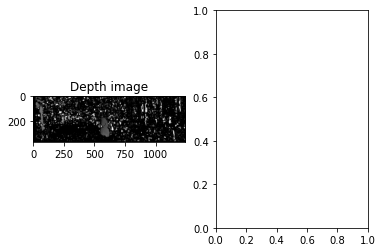

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(disparity, cmap="gray")
axs[0].set_title('Depth image')
#axs[1].imshow(depth_grayscale, cmap="gray")
#axs[1].set_title('Depth grayscale image')
plt.show()

In [ ]:

# compute point cloud:
pcd = []
height, width = disparity.shape
for i in range(height):
   for j in range(width):
       z = disparity[i][j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       pcd.append([x, y, z])

NameError: ignored

In [ ]:
# get depth resolution:
height, width = disparity.shape
length = height * width
# compute indices:
jj = np.tile(range(width), height)
ii = np.repeat(range(height), width)
# rechape depth image
z = disparity.reshape(length)
# compute pcd:
pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                 (jj - CY_DEPTH) * z / FY_DEPTH,
                 z]).reshape((length, 3))